In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix


# Load data

In [3]:
file = '/Users/danichao/self_data/data_banknote_authentication.txt'
data = pd.read_csv(file, header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])
data.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


# Drop the label and make the data for unsupervised clustering

In [4]:
data_unsupervised = data.drop(['class'], axis=1)

# Visualize the features in detail

Since now we do not know the ground truth, true note or fake note, we can only explore the feature similarity/distance among all the notes. **To quantify and calculate the feature similarity distance between varied notes, we need to rescale all the features into a same scale.** Therefore, we need to examine the distribution of each feature more carefully that what we have done in logistic regression.

In more practical words, unlike the visualization for logistic regression, we use histogram to investigate the feature distribution in more detail.

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

In [6]:
def FeatureDistribution(feature):
    fig = plt.figure(figsize=(8,3.5))
    sns.histplot(data_unsupervised.loc[:, feature], color='r', kde=True)
    plt.xlabel(feature)
    plt.ylabel('density')
    plt.show()

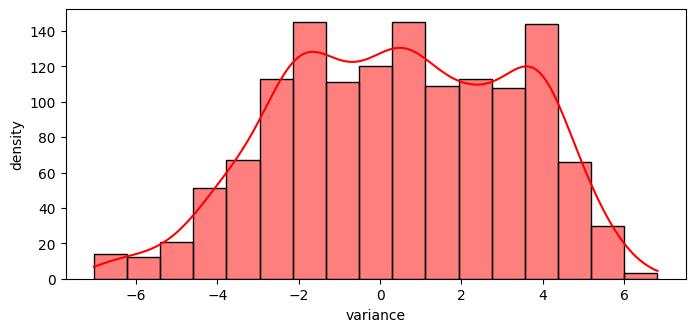

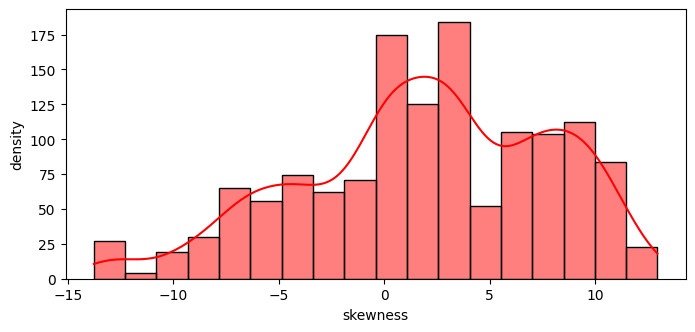

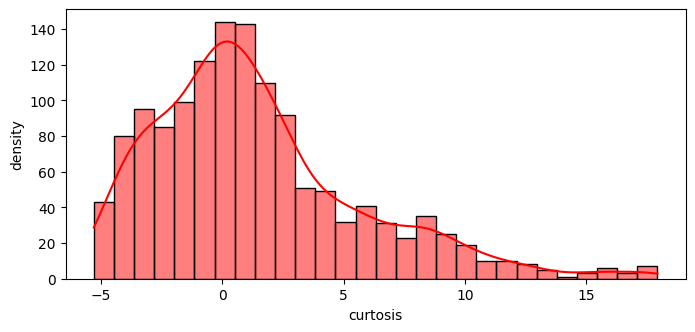

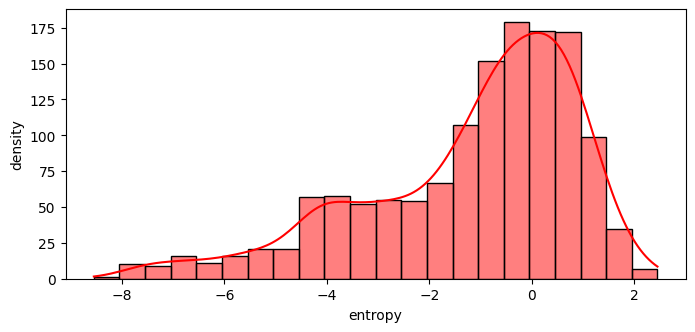

In [7]:
FeatureDistribution('variance')
FeatureDistribution('skewness')
FeatureDistribution('curtosis')
FeatureDistribution('entropy')

- `Variance` has Gaussian-like distribution, peak around the center and dropping gradually in both sides. Although the peak around the center is not sharp, the distriibution is probably a combination of two Gaussian distributions. We should apply `normalization` to variance.
- `Skewness` also has a Gaussian-like distribution, very likely to be a combination of two or three Gaussian distributions. I will apply `normalization` to skewness as well.
- `curtosis` and `entropy` are not gaussion-distributed. Both `curtosis` and `entropy` have peaks toward to one end, but neither of them has perfect power-law distribution. The better way to rescale/standardize them is to `create quantiles`.

# Rescaling features: normalization & quantile scaling

### Normalization for `variance` and `skewness`

In [8]:
def FeatureNormalization(feature):
    norm_feature = '{}_norm'.format(feature)
    data_unsupervised[norm_feature] = (data_unsupervised[feature] - data_unsupervised[feature].mean())/data_unsupervised[feature].std()

In [9]:
normalization_features = ['variance', 'skewness']

for feature in normalization_features:
    FeatureNormalization(feature)

### Create quantile for `curtosis` and `entropy`

In [10]:
def FeatureQuantile(feature, numQuant):
    quant_feature = '{}_quant'.format(feature)
    scale_feature = '{}_scale'.format(feature)
    data_unsupervised[quant_feature] = pd.qcut(data_unsupervised[feature], numQuant, duplicates='drop', labels=False)
    data_unsupervised[scale_feature] = (data_unsupervised[quant_feature] - data_unsupervised[quant_feature].min()) / (data_unsupervised[quant_feature].max() - data_unsupervised[quant_feature].min())

In [11]:
quantile_features = ['curtosis', 'entropy']
num_quantiles = 10

for feature in quantile_features:
    FeatureQuantile(feature, num_quantiles)

In [12]:
data_unsupervised

,variance,skewness,curtosis,entropy,variance_norm,skewness_norm,curtosis_quant,curtosis_scale,entropy_quant,entropy_scale
0,3.62160,8.66610,-2.8073,-0.44699,1.121397,1.149036,1,0.111111,5,0.555556
1,4.54590,8.16740,-2.4586,-1.46210,1.446538,1.064065,1,0.111111,3,0.333333
2,3.86600,-2.63830,1.9242,0.10645,1.207369,-0.777069,6,0.666667,6,0.666667
3,3.45660,9.52280,-4.0112,-3.59440,1.063355,1.295005,0,0.000000,1,0.111111
4,0.32924,-4.45520,4.5718,-0.98880,-0.036758,-1.086642,8,0.888889,4,0.444444
...,...,...,...,...,...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,-0.009707,-0.097657,2,0.222222,5,0.555556
1368,-1.38870,-4.87730,6.4774,0.34179,-0.641079,-1.158562,8,0.888889,7,0.777778
1369,-3.75030,-13.45860,17.5932,-2.77710,-1.471820,-2.620690,9,1.000000,2,0.222222
1370,-3.56370,-8.38270,12.3930,-1.28230,-1.406180,-1.755831,9,1.000000,3,0.333333


# Drop unprocessed features for clustering

In [13]:
data_unsupervised = data_unsupervised.drop(
                     ['variance', 'skewness', 'curtosis', 'entropy', 'curtosis_quant', 'entropy_quant'], 
                     axis=1)
data_unsupervised.head()

,variance_norm,skewness_norm,curtosis_scale,entropy_scale
0,1.121397,1.149036,0.111111,0.555556
1,1.446538,1.064065,0.111111,0.333333
2,1.207369,-0.777069,0.666667,0.666667
3,1.063355,1.295005,0.000000,0.111111
4,-0.036758,-1.086642,0.888889,0.444444


# K-Means clustering

Without the ground truth whether a bank note is true or fake, my goal here is to separate all the bank notes into two clusters. These two clusters will correpond to true note and fake note in prediction, though we will not know the exact relation between the model clusters and true-or-fake notes.

I use K-Means clustering divide the bank notes. K-means is an unsupervised learning algorithm to segment a dataset into K clusters. I set K = 2 here. 

In [14]:
from sklearn.cluster import KMeans

In [22]:
kmeans_model = KMeans(n_clusters=2, random_state=0, n_init="auto")

In [23]:
kmeans_model.fit(data_unsupervised)

KMeans(n_clusters=2, random_state=0)

In [24]:
labels = kmeans_model.labels_
data_results = data_unsupervised.copy()
data_results['cluster'] = labels
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster
0,1.121397,1.149036,0.111111,0.555556,0
1,1.446538,1.064065,0.111111,0.333333,0
2,1.207369,-0.777069,0.666667,0.666667,0
3,1.063355,1.295005,0.000000,0.111111,0
4,-0.036758,-1.086642,0.888889,0.444444,1
...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0
1368,-0.641079,-1.158562,0.888889,0.777778,1
1369,-1.471820,-2.620690,1.000000,0.222222,1
1370,-1.406180,-1.755831,1.000000,0.333333,1


If cluster-0 is true bank note, then cluster-1 is false bank note, or vice versa.

***Note: Since the clustering is unsupervised and there is no ground truth, K-Means clustering is very dependent on the initial centroids of the clusters that are chosen randomly by the algorithm. When K-Means clustering is not suitable for dataset, the initial centroids will easily become extreme, hence unreliable and unstable clustering result. To examine this, it is better to run K-Means clustering multiple times and check cluster centroids.***

## Examine model stability

In [25]:
centroids = kmeans_model.cluster_centers_

In [26]:
d = {'variance_centroids': centroids[:, 0],
     'skewness_centroids': centroids[:, 1],
     'curtosis_centroids': centroids[:, 2],
     'entropy_centroids': centroids[:, 3]}

binary_centroids = pd.DataFrame(data=d)
binary_centroids

,variance_centroids,skewness_centroids,curtosis_centroids,entropy_centroids
0,0.639278,0.493364,0.383412,0.478873
1,-0.844799,-0.651975,0.653882,0.527355


In [27]:
n_iter = 7
centers = []

for i in range(n_iter):
    kmeans_model = KMeans(n_clusters=2, n_init="auto")
    kmeans_model.fit(data_unsupervised)
    
    labels = kmeans_model.labels_
    result_col = "cluster_{}".format(i+1)
    data_results[result_col] = labels

    centroids = kmeans_model.cluster_centers_
    variance_centroids_col = "variance_centroids_{}".format(i+1)
    skewness_centroids_col = "skewness_centroids_{}".format(i+1)
    curtosis_centroids_col = "curtosis_centroids_{}".format(i+1)
    entropy_centroids_col = "entropy_centroids_{}".format(i+1)

    centroids_cols = [variance_centroids_col, skewness_centroids_col, curtosis_centroids_col, entropy_centroids_col]
    for j in range(len(centroids_cols)):
        binary_centroids[centroids_cols[j]] = centroids[:, j]

variance_centroids_1
skewness_centroids_1
curtosis_centroids_1
entropy_centroids_1
variance_centroids_2
skewness_centroids_2
curtosis_centroids_2
entropy_centroids_2
variance_centroids_3
skewness_centroids_3
curtosis_centroids_3
entropy_centroids_3
variance_centroids_4
skewness_centroids_4
curtosis_centroids_4
entropy_centroids_4
variance_centroids_5
skewness_centroids_5
curtosis_centroids_5
entropy_centroids_5
variance_centroids_6
skewness_centroids_6
curtosis_centroids_6
entropy_centroids_6
variance_centroids_7
skewness_centroids_7
curtosis_centroids_7
entropy_centroids_7


In [28]:
binary_centroids

,variance_centroids,skewness_centroids,curtosis_centroids,entropy_centroids,variance_centroids_1,skewness_centroids_1,curtosis_centroids_1,entropy_centroids_1,variance_centroids_2,skewness_centroids_2,...,curtosis_centroids_5,entropy_centroids_5,variance_centroids_6,skewness_centroids_6,curtosis_centroids_6,entropy_centroids_6,variance_centroids_7,skewness_centroids_7,curtosis_centroids_7,entropy_centroids_7
0,0.639278,0.493364,0.383412,0.478873,-0.847832,-0.655464,0.656274,0.528156,-0.850047,-0.657598,...,0.382245,0.478513,-0.845644,-0.653352,0.654614,0.527872,-0.844047,-0.650576,0.652778,0.526652
1,-0.844799,-0.651975,0.653882,0.527355,0.635874,0.491598,0.382653,0.478458,0.633750,0.490270,...,0.657755,0.528252,0.638018,0.492939,0.383205,0.478545,0.640610,0.493770,0.383903,0.479345


In [29]:
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,1.121397,1.149036,0.111111,0.555556,0,1,1,1,0,0,1,1
1,1.446538,1.064065,0.111111,0.333333,0,1,1,1,0,0,1,1
2,1.207369,-0.777069,0.666667,0.666667,0,1,1,1,0,0,1,1
3,1.063355,1.295005,0.000000,0.111111,0,1,1,1,0,0,1,1
4,-0.036758,-1.086642,0.888889,0.444444,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0,1,1,1,0,0,1,1
1368,-0.641079,-1.158562,0.888889,0.777778,1,0,0,0,1,1,0,0
1369,-1.471820,-2.620690,1.000000,0.222222,1,0,0,0,1,1,0,0
1370,-1.406180,-1.755831,1.000000,0.333333,1,0,0,0,1,1,0,0


## Visualize stability

In [58]:
def StabilityVisualization(feature):
    centroid_feature = f"{feature}_centroids"

    if feature in ["variance", "skewness"]:
        feature = f"{feature}_norm"
    else:
        feature = f"{feature}_scale"

    cluster = "cluster"
    for i in range(7):

        cluster_iter = cluster
        centroid_feature_iter = centroid_feature

        if i !=0:
            cluster_iter = f"{cluster_iter}_{i}"
            centroid_feature_iter = f"{centroid_feature_iter}_{i}"


        data_0 = data_results[data_results[cluster_iter] == 0]
        data_1 = data_results[data_results[cluster_iter] == 1]

        fig = plt.figure(figsize=(8, 3.5))
        sns.histplot(data_0[feature], color='r', kde=True, label="Cluster 0")
        sns.histplot(data_1[feature], color='b', kde=True, label="Cluster 1")
        plt.axvline(x = binary_centroids[centroid_feature_iter][0], color = 'r', label="Centroid 0")
        plt.axvline(x = binary_centroids[centroid_feature_iter][1], color = 'b', label="Centroid 1")
        plt.xlabel(feature)
        plt.ylabel('density')
        plt.legend(loc="upper left")
        plt.show()

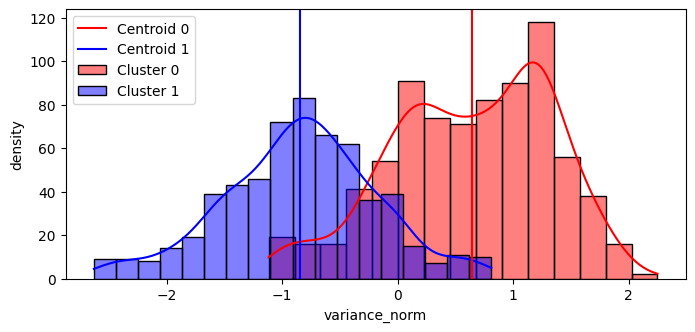

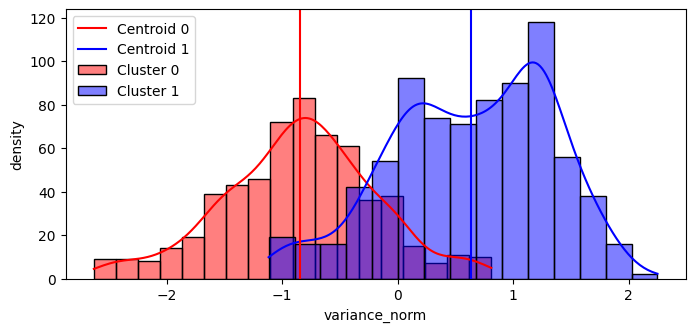

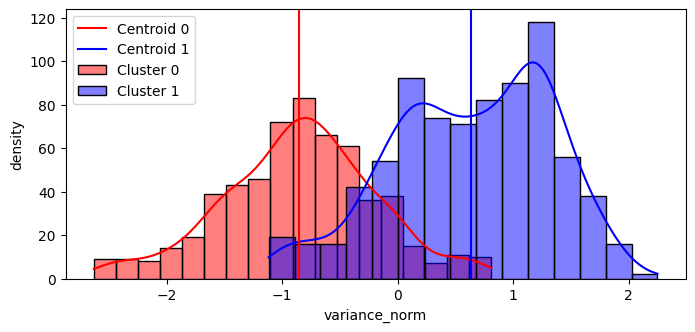

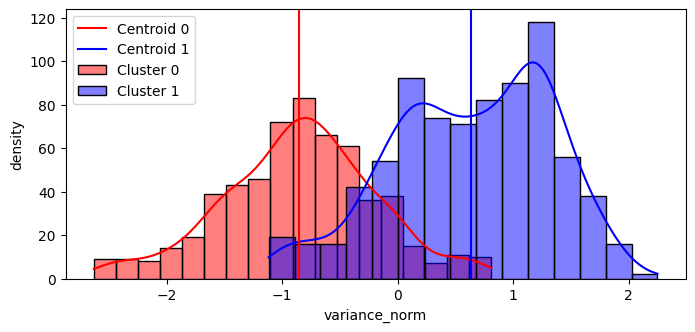

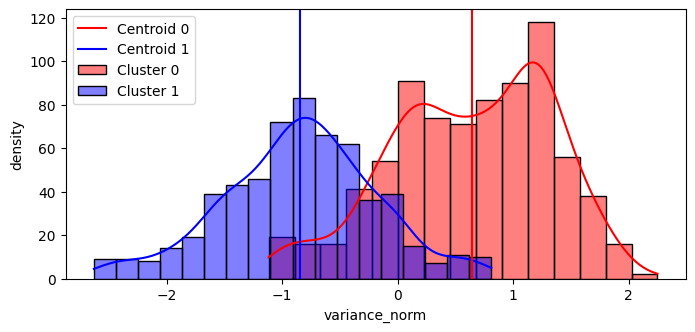

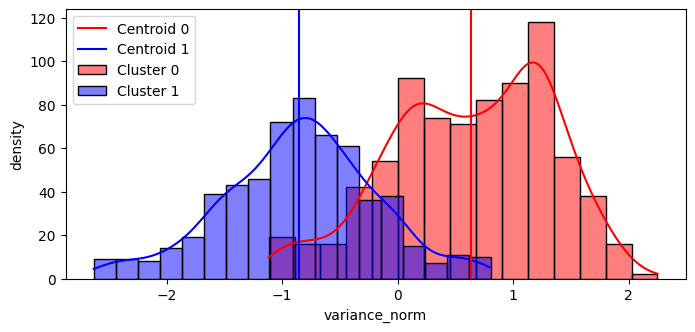

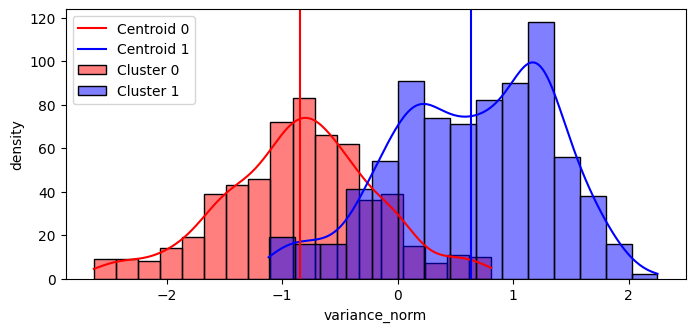

In [59]:
StabilityVisualization("variance")

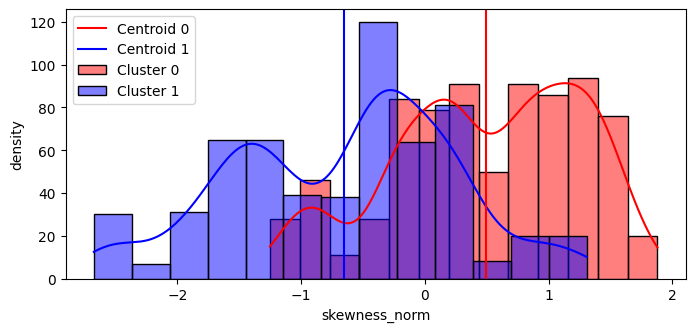

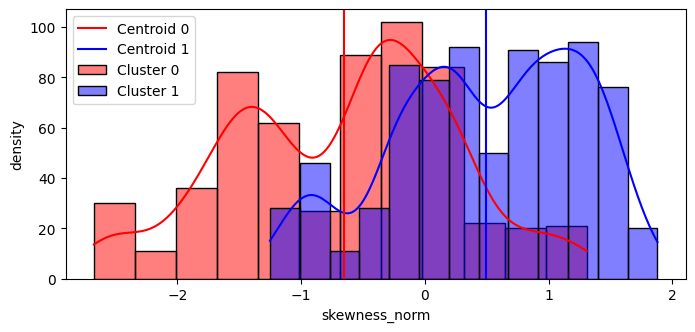

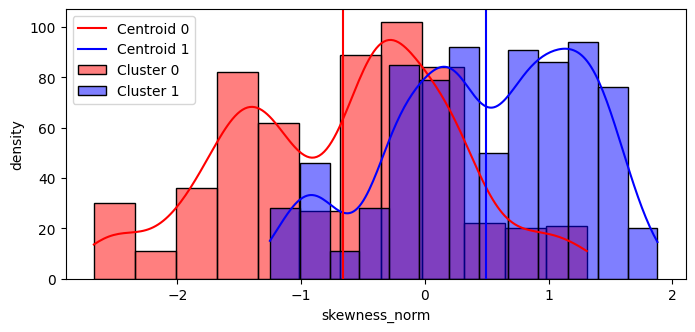

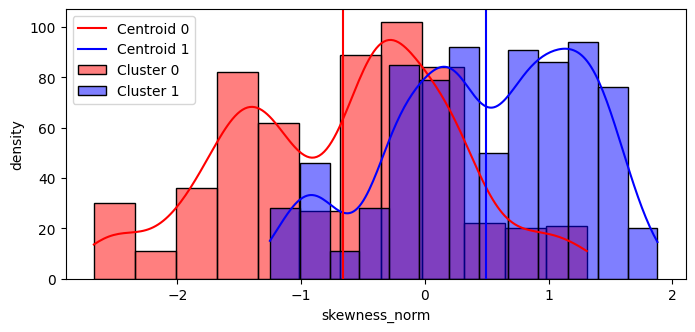

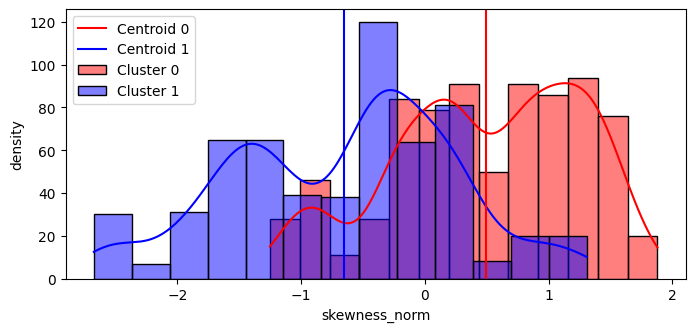

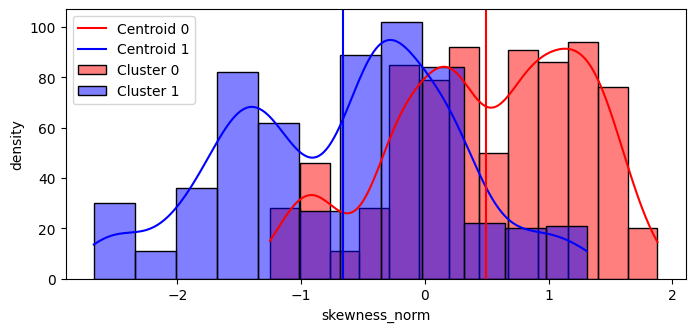

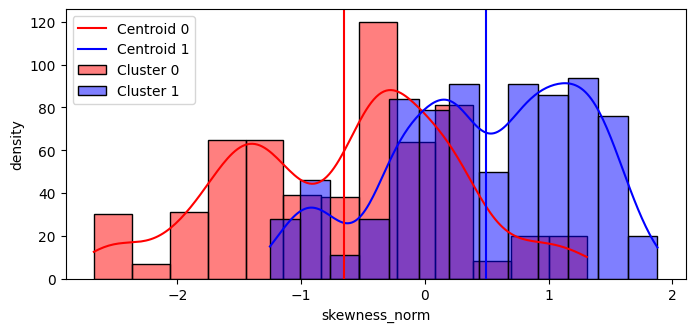

In [60]:
StabilityVisualization("skewness")

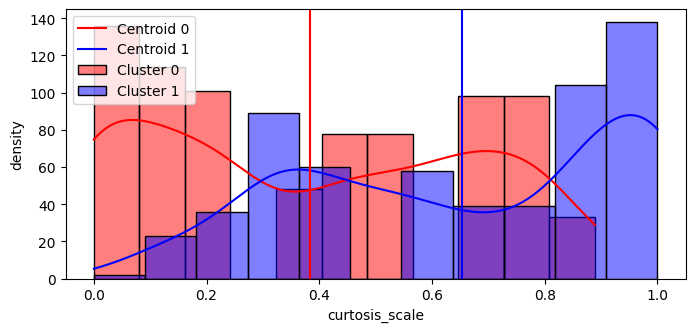

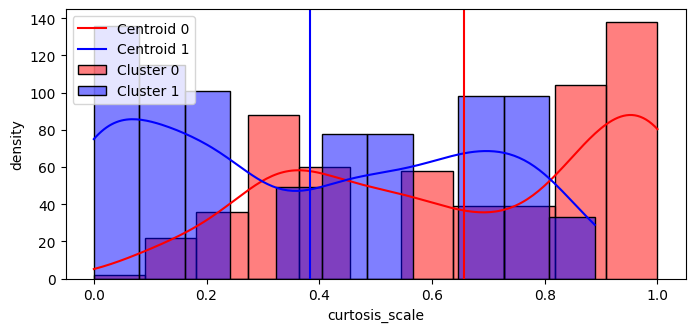

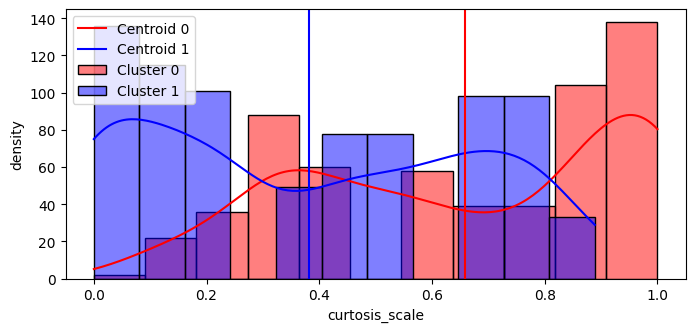

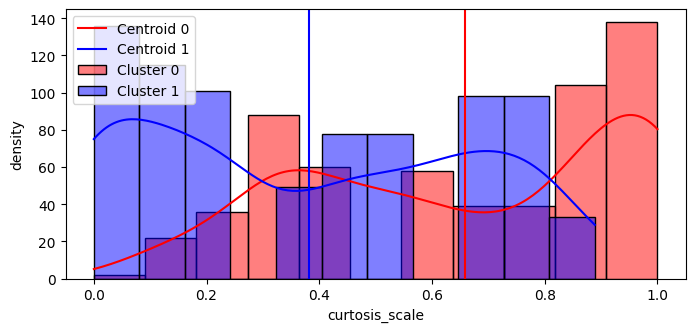

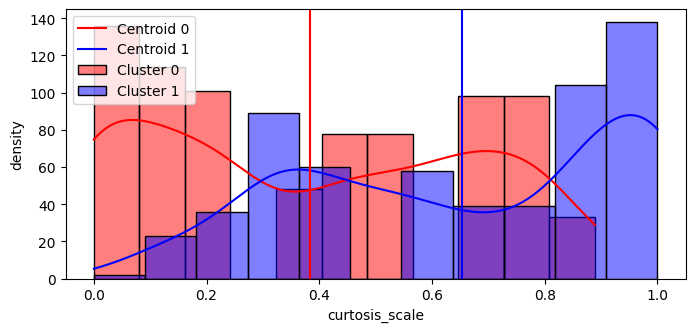

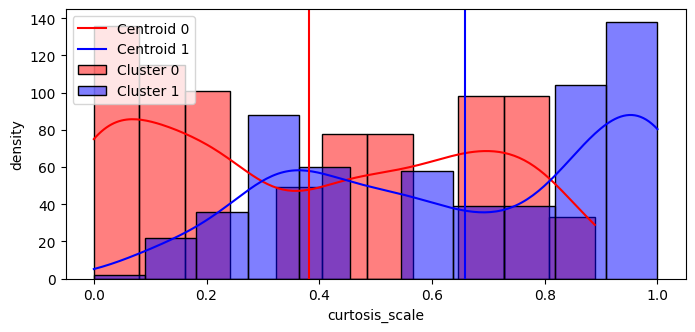

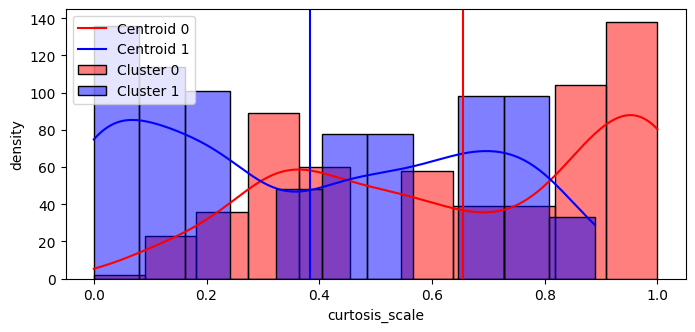

In [61]:
StabilityVisualization("curtosis")

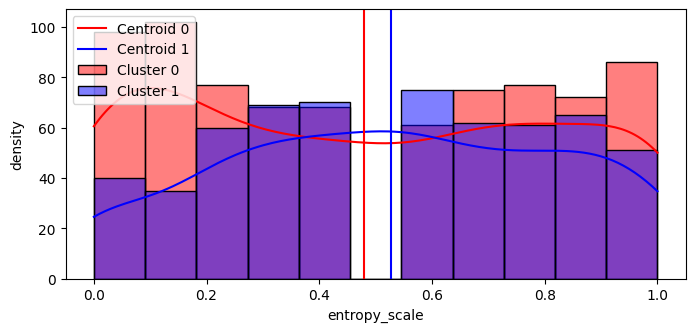

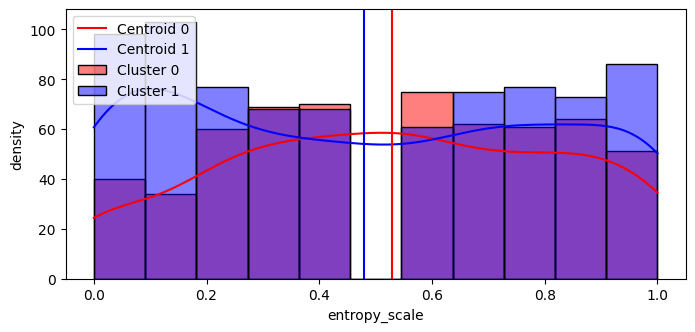

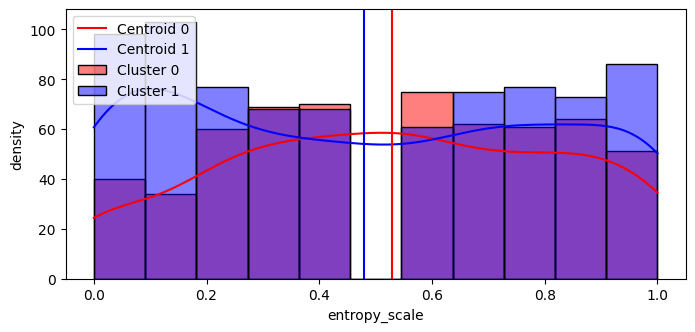

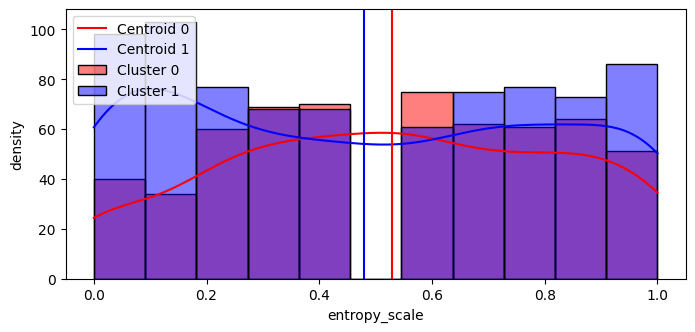

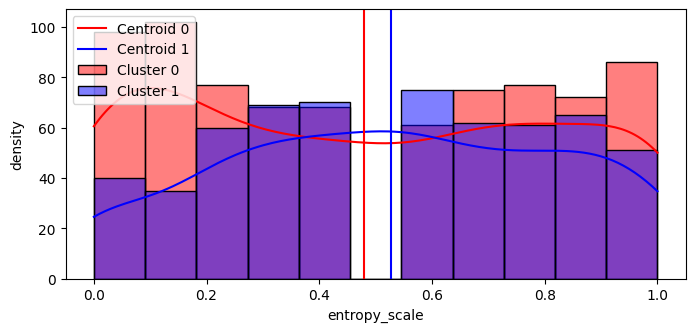

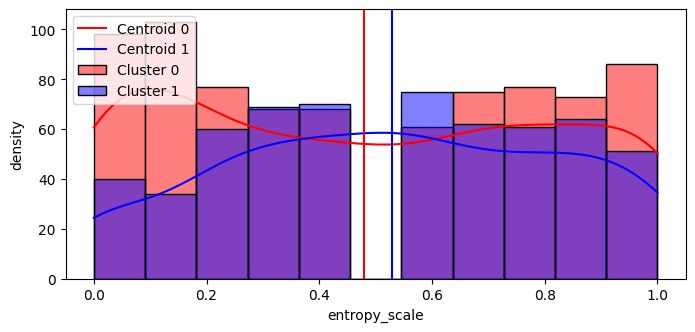

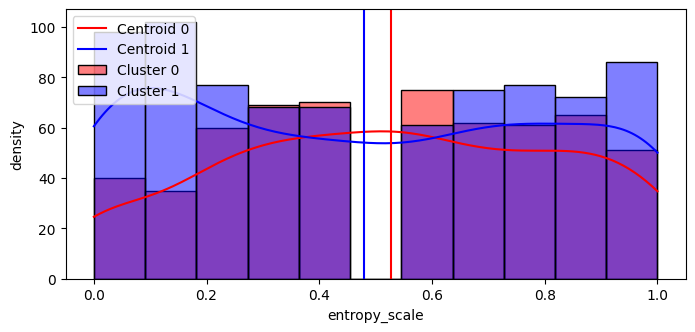

In [62]:
StabilityVisualization("entropy")

To check K-Means clustering stability, what really matters the most is the ***coverage/terrain of each cluster does not vary among different clustering iterations***. As long as most of objects in one cluster stay in a same cluster, it does not matter that objects are categorized as another cluster in another iteration. For our two-cluster case here, it is completely fine and normal that cluster-0 and cluster-1 switch to each other in varied K-Means cluster runs.

***Therefore, K-Means clustering works well on our dataset for true-or-fake bank note separation. In the eight K-Means iterations, the two clusters cover almost the same feature distributions, and the cluster centroids are similar among the four rescaled features.***

# Evaluate the model

Now I would like to further check the quality and performance of our K-Means clustering model. Since K-Means clustering is stable across various iterations, I will use `cluster` to analyze and drop other clustering results (`cluster_1`, ..., `cluster_7`).

In [64]:
data_results = data_results.drop(['cluster_1', 'cluster_2', 'cluster_3',
                                  'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'], axis=1)
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster
0,1.121397,1.149036,0.111111,0.555556,0
1,1.446538,1.064065,0.111111,0.333333,0
2,1.207369,-0.777069,0.666667,0.666667,0
3,1.063355,1.295005,0.000000,0.111111,0
4,-0.036758,-1.086642,0.888889,0.444444,1
...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0
1368,-0.641079,-1.158562,0.888889,0.777778,1
1369,-1.471820,-2.620690,1.000000,0.222222,1
1370,-1.406180,-1.755831,1.000000,0.333333,1


In [76]:
binary_centroids = binary_centroids[['variance_centroids', 'skewness_centroids', 'curtosis_centroids', 'entropy_centroids']]
binary_centroids

,variance_centroids,skewness_centroids,curtosis_centroids,entropy_centroids
0,0.639278,0.493364,0.383412,0.478873
1,-0.844799,-0.651975,0.653882,0.527355


In [77]:
data_results[data_results['cluster'] == 0]

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster
0,1.121397,1.149036,0.111111,0.555556,0
1,1.446538,1.064065,0.111111,0.333333,0
2,1.207369,-0.777069,0.666667,0.666667,0
3,1.063355,1.295005,0.000000,0.111111,0
5,1.384099,1.320393,0.000000,0.111111,0
...,...,...,...,...,...
1352,0.371422,0.256677,0.000000,0.333333,0
1353,-0.111798,0.221424,0.111111,0.222222,0
1359,-0.129313,0.096957,0.111111,0.444444,0
1360,-0.239621,0.002462,0.111111,0.444444,0


## Cardinality versus magnitude

`Cardinality` is the number of samples in a cluster. `Magnitude` is the sum of the distances between each sample in a cluster and the cluster centroid. Generally, `cardinality` and `magnitude` help us to find outliers. For example, if a cluster has average `cardinality` but large `magnitude`, then it is very likely that this cluser contains outliers.

In [66]:
# Calculate cardinality
card_0 = len(np.where(data_results['cluster'] == 0)[0])
card_1 = len(np.where(data_results['cluster'] == 1)[0])
cardinality = np.array([card_0, card_1])

In [90]:
# Calculate magnitude
def Distance_2_Centroid(point, centroid):
    dist = np.linalg.norm(point - centroid)

    return dist

In [105]:
features = data_results.drop(['cluster'], axis=1)

magnitude_0 = 0
magnitude_1 = 0
for i in range(len(features)):
    if data_results['cluster'][i] == 0:
        magnitude_0 += Distance_2_Centroid(np.array(features.iloc[i, :]), np.array(binary_centroids.iloc[0, :]))
    else:
        magnitude_1 += Distance_2_Centroid(np.array(features.iloc[i, :]), np.array(binary_centroids.iloc[1, :]))

magnitude = [magnitude_0, magnitude_1]

Text(0.5, 1.0, 'Magnitude')

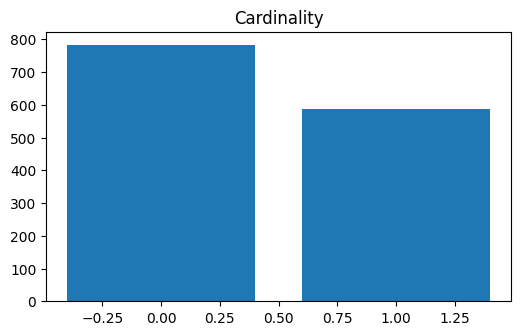

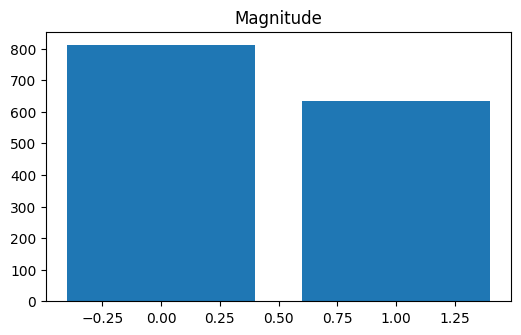

In [115]:
fig = plt.figure(figsize=(6, 3.5))
plt.bar([0, 1], cardinality)
plt.title('Cardinality')

fig = plt.figure(figsize=(6, 3.5))
plt.bar([0, 1], magnitude)
plt.title('Magnitude')

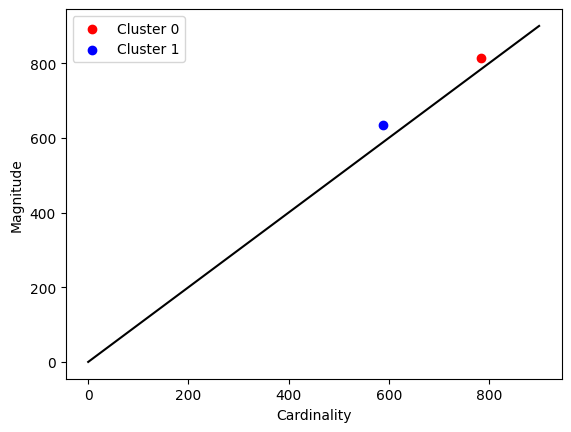

In [120]:
plt.scatter(cardinality[0], magnitude[0], color='red', label='Cluster 0')
plt.scatter(cardinality[1], magnitude[1], color='blue', label='Cluster 1')
plt.plot([0, 900], [0, 900], color='black')
plt.xlabel('Cardinality')
plt.ylabel('Magnitude')
plt.legend()

Our cardinality-magnitude metrics look reasonable: 

- Cardinality-magnitude relation is close to line of cardinality = magnitude.
- From the bar plots, we can already see that cardinality and magnitude are very likely at the same trends. Cluster 0 has both higher cardinality and higher magnitude, and cluster 1 has both lower cardinality and lower magnitude. Furthermore, the levels of difference between cluster 0 and cluster 1 are similar in both cardinality and magnitude.

***Our K-Means clustering model has good quality. Now you only need to pick one bank note and ask an expert to verify this bank note, you will be ready to go. If this picked note is true, then the other band notes in the same cluster are also true bank notes; the banks notes in the other cluster will be fake bank notes, and vice versa. (The expert is expensive, so you can only afford the verification for one bank note!)***

# God's view

When we need to use K-Means clustering to tackle the problem, it usually means that we do not know the ground truth to segment the given dataset. Here, let us assume we finally know the ground truth years after we separate the true bank notes from the fake bank notes, and like a hitorian, we would like to use the ground truth to examine if the years-back decision (true-or-fake notes) is good or bad.

In other words, we use the true-or-fake label that we drop in the beginning to examine our K-Means clustering model.

In [121]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

In [124]:
data_results['ground_truth'] = data['class']
data_results

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,ground_truth
0,1.121397,1.149036,0.111111,0.555556,0,0
1,1.446538,1.064065,0.111111,0.333333,0,0
2,1.207369,-0.777069,0.666667,0.666667,0,0
3,1.063355,1.295005,0.000000,0.111111,0,0
4,-0.036758,-1.086642,0.888889,0.444444,1,0
...,...,...,...,...,...,...
1367,-0.009707,-0.097657,0.222222,0.555556,0,1
1368,-0.641079,-1.158562,0.888889,0.777778,1,1
1369,-1.471820,-2.620690,1.000000,0.222222,1,1
1370,-1.406180,-1.755831,1.000000,0.333333,1,1


### Verify the assumption: cluster-0 is fake notes

To evaluate the unsupervised clustering, we first need to guess if ***cluster-0 is fake*** notes and verify. If the verification fails, I will continue with that ***cluster-0 is true***.

In [125]:
data_results[data_results['cluster'] == data_results['ground_truth']]

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,ground_truth
0,1.121397,1.149036,0.111111,0.555556,0,0
1,1.446538,1.064065,0.111111,0.333333,0,0
2,1.207369,-0.777069,0.666667,0.666667,0,0
3,1.063355,1.295005,0.000000,0.111111,0,0
5,1.384099,1.320393,0.000000,0.111111,0,0
...,...,...,...,...,...,...
1366,-1.000342,0.310263,0.333333,0.333333,1,1
1368,-0.641079,-1.158562,0.888889,0.777778,1,1
1369,-1.471820,-2.620690,1.000000,0.222222,1,1
1370,-1.406180,-1.755831,1.000000,0.333333,1,1


In [126]:
data_results[data_results['cluster'] != data_results['ground_truth']]

,variance_norm,skewness_norm,curtosis_scale,entropy_scale,cluster,ground_truth
4,-0.036758,-1.086642,0.888889,0.444444,1,0
7,0.583399,-1.487866,1.000000,0.444444,1,0
18,0.356753,-1.158920,1.000000,0.222222,1,0
21,-0.036772,-1.086642,0.888889,0.444444,1,0
25,0.095669,-1.264337,1.000000,0.222222,1,0
...,...,...,...,...,...,...
1352,0.371422,0.256677,0.000000,0.333333,0,1
1353,-0.111798,0.221424,0.111111,0.222222,0,1
1359,-0.129313,0.096957,0.111111,0.444444,0,1
1360,-0.239621,0.002462,0.111111,0.444444,0,1


I am lucky that the guess is correct. I will continue with ***cluster-0 is fake notes***.

In [133]:
y_true = data_results['ground_truth'].values
y_predict = data_results['cluster'].values

result_confusion_mat = confusion_matrix(y_true, y_predict)
tn, fp, fn, tp = result_confusion_mat.ravel()

print('Clustering accuracy:', accuracy_score(y_true, y_predict))
print('Clustering precision:', precision_score(y_true, y_predict))
print('Clustering recall:', recall_score(y_true, y_predict))
print('Clustering f1 score:', f1_score(y_true, y_predict))
print('\n')
print('Number of true negative:', tn)
print('Number of false positive:', fp)
print('Number of true positive:', tp)
print('Number of false negative:', fn)

Clustering accuracy: 0.8600583090379009
Clustering precision: 0.8554421768707483
Clustering recall: 0.8245901639344262
Clustering f1 score: 0.8397328881469115


Number of true negative: 677
Number of false positive: 85
Number of true positive: 503
Number of false negative: 107


### Overall, our clustering on true-or-fake bank notes without ground truth is not bad, mainly due to our careful procedure preprocessing the four features with normalization and scaling.